# Adding new components

In this tutorial we will show how to add new components to the QSPRpred package. 
QSPRpred is designed to be modular, so that new components can be added easily.
Here we will give some general explanation on how to add new components and give two examples (adding a new descriptor and a new model).

## General explanation

Each module in QSPRpred has a `interfaces.py` file that contains base classes for the components of that module.
These base classes are used to define the interface of the components and to ensure that the components are compatible with the rest of the package.
The base classes are not meant to be used directly, but rather to be subclassed by the user to create new components.
You can see the base classes as a template that you can use to create your own components.

Steps to add a new component:
1. Find the base class for the component you want to add in the `interfaces.py` file of the module you want to add the component to.
2. Create a new class that inherits from the base class.
3. Implement the abstract methods of the base class in your new class.
4. Check the inputs and outputs of the new methods match the ones defined in the base class (see the docstrings of the base class).
5. Check that your new class is compatible with the rest of the package by running the tests.

## Adding a new descriptor

## Adding a new model

Here we will show how to create a new `QSPRModel` that uses GZIP-KNN as the underlying estimator.
Below I added the code for the Gzip KNN algorithm as described in [1], which is a _k_-nearest neighbors algorithm that uses the ncd (normalized compression distance) as the distance metric.

[1] Jiang, Zhiying et al. 2023. “‘Low-Resource’ Text Classification: A Parameter-Free Classification Method with Compressors.” In Findings of the Association for Computational Linguistics: ACL 2023, Toronto, Canada: Association for Computational Linguistics, 6810–28. https://aclanthology.org/2023.findings-acl.426 (July 14, 2023).

In [1]:
import gzip
import numpy as np

def gzip_knn(X_train: np.ndarray, y_train: np.ndarray, X_test, k: int = 3):
    """Predict class for each test instance using k-nearest neighbors with normalized compression distance.
    
    Adapted from Jiang et al.(2023), https://doi.org/10.48550/arXiv.2212.09410

    Args:
        X_train (np.ndarray): training set input (SMILES strings)
        y_train (np.ndarray): training set output (class labels)
        X_train (np.ndarray): test set input (SMILES strings)
        k (int): number of nearest neighbors to consider
        
    Returns:
        predict_class (list[str]): predicted class for each test instance
    """
    predicted_class = []
    for (x1) in X_test: 
        Cx1 = len(gzip.compress(x1.encode()))
        distance_from_x1 = []
        for (x2) in X_train: 
            Cx2 = len(gzip.compress(x2.encode()))
            x1x2 = "".join([x1 , x2])
            Cx1x2 = len(gzip.compress(x1x2.encode()))
            ncd = (Cx1x2 - min ( Cx1 , Cx2 )) / max (Cx1 , Cx2)
            distance_from_x1.append(ncd)
        sorted_idx = np.argsort(np.array(distance_from_x1))
        top_k_class = y_train[sorted_idx[:k]]
        predicted_class.append(max(set(top_k_class), key = list(top_k_class).count))
    return predicted_class


# Example training set
smiles_train = np.array(["c1ccccc1", "c1ccccc1C","c1ccccc1CC","c1ccccc1CCC","Fc1ccccc1F","Clc1ccccc1Cl"])
train_class = np.array(["ClassA", "ClassB", "ClassA", "ClassB", "ClassB", "ClassB"])
smiles_test = np.array(["c1ccccc1", "c1ccccc1C", "c1ccccc1F", "CCX"])

print(gzip_knn(X_train=smiles_train, y_train=train_class, X_test=smiles_test))

['ClassB', 'ClassA', 'ClassB', 'ClassA']


As we want to use this algorithm to do cross-validation and hyperparameter optimization, let's have a quick look if we can speed up the algorithm by replacing the double for loop with a vectorized implementation. Also we will return the class probabilities in addition to the predicted class, by dividing the number of neighbors of each class by the total number of neighbors in the majority voting.

In [2]:
from itertools import product

def gzip_knn_fast(X_train, y_train, X_test, k: int = 3):
    """Predict class for each test instance using k-nearest neighbors with normalized compression distance.
    
    Adapted from Jiang et al.(2023), https://doi.org/10.48550/arXiv.2212.09410

    Args:
        X_train (np.ndarray): training set input (SMILES strings)
        y_train (np.ndarray): training set output (class labels)
        X_train (np.ndarray): test set input (SMILES strings)
        k (int): number of nearest neighbors to consider
        
    Returns:
        predict_class (list[str]): predicted class for each test instance
    """
    classes = np.unique(y_train)
    class_label_map = {c: i for i, c in enumerate(classes)}
    class_probabilities = []
    predicted_class = []

    # Convert class labels to integers
    training_labels = np.array([class_label_map[label] for label in y_train])

    # Compute compressed lengths for training set and test set
    training_compressed_lengths = np.array([len(gzip.compress(x.encode())) for x in X_train])
    test_compressed_lengths = np.array([len(gzip.compress(x.encode())) for x in X_test])

    # Combine sets and compute compressed lengths
    combined_strings = np.array(list(map(''.join, product(X_test, X_train))))
    combined_compressed_lengths = np.array([len(gzip.compress(x.encode())) for x in combined_strings]).reshape(len(X_test), len(X_train))

    # Compute NCD matrix
    ncd_matrix = (combined_compressed_lengths - np.minimum.outer(test_compressed_lengths, training_compressed_lengths)) / np.maximum.outer(test_compressed_lengths, training_compressed_lengths)

    # Find the top-k classes for each test instance
    top_k_indices = np.argsort(ncd_matrix, axis=1)[:, :k]
    top_k_classes = training_labels[top_k_indices]

    # Compute predicted class and class probabilities
    predicted_class = np.array([np.argmax(np.bincount(row)) for row in top_k_classes])
    class_probabilities = np.array([np.bincount(row, minlength=len(classes)) / k for row in top_k_classes])

    # Map predicted class back to original labels
    predicted_class = np.array([classes[label] for label in predicted_class])

    return predicted_class, class_probabilities

In [3]:
# test speed of gzip_knn

# create larger training set
TRAIN_SIZE, TEST_SIZE, REPEATS = 1000, 100, 5
smiles_train_large = np.array(["c1ccccc1"] * TRAIN_SIZE)
train_class_large = np.array([np.random.choice(["ClassA", "ClassB", "ClassC"]) for i in range(TRAIN_SIZE)])
smiles_test_large = np.array(["c1ccccc1"] * TEST_SIZE)

# original gzip_knn
import timeit
print(timeit.timeit(lambda: gzip_knn(X_train=smiles_train_large, y_train=train_class_large, X_test=smiles_test_large), number=REPEATS) / REPEATS)

# faster gzip_knn
print(timeit.timeit(lambda: gzip_knn_fast(X_train=smiles_train_large, y_train=train_class_large, X_test=smiles_test_large), number=REPEATS) / REPEATS)

2.5055147000122817
1.2816359400050714


This significantly speeds up the algorithm, so let's continue with the second implementation. 

Now for the implementation of the `QSPRModel` Gzip KNN, we find the base class for models `QSPRModels` in the `interfaces.py` file of the `models` module.
In the `models.py` file of the `models` module you can also find an example of a model that inherits from the base class `QSPRSklearn`, which uses estimators from the `scikit-learn` package.

There are six abstract methods that need to be implemented from `QSPRModel` class in our new class `GzipKNNModel`:
- `fit`, which trains the model
- `predict`, which makes predictions with the trained model
- `predictProba`, which makes probability predictions with the trained model (classification only)
- `loadEstimator`, which loads a new estimator instance from given parameters
- `loadEstimatorFromFile`, wich loads a new estimator instance from a file
- `saveEstimator`, which saves the estimator instance to a file

But before we implement these methods, we just re-write the algorithm as a class so that we can use it as an estimator in the `GzipKNNModel` class. The only thing that is added here is an `__init__` method, to save some parameters of the algorithm, for example to use in the `saveEstimator` method.

In [4]:
import gzip
import numpy as np
from typing import Tuple
from itertools import product

class GzipKNNAlgorithm():
    """A KNN algorithm using the NCD metric to calculate the distance between two strings.
    
    Attributes:
        k (int): number of nearest neighbors to consider
        X_train (np.ndarray): training set input (SMILES strings)
        y_train (np.ndarray): training set output (class labels)
    """
    
    def __init__(self, k: int = 3):
        """Initialize the gzip knn algorithm.
        
        Args:
            k (int): number of nearest neighbors to consider
        """
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def __call__(self, X_test: np.ndarray) -> Tuple[list[str | int], list[list[float]]]:
        """Predict class for each test instance using k-nearest neighbors with normalized compression distance.
    
        Adapted from Jiang et al.(2023), https://doi.org/10.48550/arXiv.2212.09410
        
        Args:
            X_test (np.ndarray): test set input (SMILES strings)
            
        Returns:
            predict_class (list): predicted class for each test instance
            class_probabilities (list): probability of each class for each test instance
        """
        # Convert class labels to integers
        classes = np.unique(self.y_train)
        class_label_map = {c: i for i, c in enumerate(classes)}
        class_probabilities = []
        predicted_class = []

        # Convert class labels to integers
        training_labels = np.array([class_label_map[label] for label in self.y_train])

        # Compute compressed lengths for training set and test set
        training_compressed_lengths = np.array([len(gzip.compress(x.encode())) for x in self.X_train])
        test_compressed_lengths = np.array([len(gzip.compress(x.encode())) for x in X_test])

        # Combine sets and compute compressed lengths
        combined_strings = np.array(list(map(''.join, product(X_test, self.X_train))))
        combined_compressed_lengths = np.array([len(gzip.compress(x.encode())) for x in combined_strings]).reshape(len(X_test), len(self.X_train))

        # Compute NCD matrix
        ncd_matrix = (combined_compressed_lengths - np.minimum.outer(test_compressed_lengths, training_compressed_lengths)) / np.maximum.outer(test_compressed_lengths, training_compressed_lengths)

        # Find the top-k classes for each test instance
        top_k_indices = np.argsort(ncd_matrix, axis=1)[:, :self.k]
        top_k_classes = training_labels[top_k_indices]

        # Compute predicted class and class probabilities
        predicted_class = np.array([np.argmax(np.bincount(row)) for row in top_k_classes])
        class_probabilities = np.array([np.bincount(row, minlength=len(classes)) / self.k for row in top_k_classes])

        # Map predicted class back to original labels
        predicted_class = np.array([classes[label] for label in predicted_class])

        return predicted_class, class_probabilities

k = 3
gzip_knn = GzipKNNAlgorithm(k)
gzip_knn.X_train = smiles_train
gzip_knn.y_train = train_class
print(gzip_knn(X_test=smiles_test))

(array(['ClassB', 'ClassA', 'ClassB', 'ClassA'], dtype='<U6'), array([[0.33333333, 0.66666667],
       [0.66666667, 0.33333333],
       [0.33333333, 0.66666667],
       [0.66666667, 0.33333333]]))


Finally, we create the `GzipKNNModel` class that inherits from the `QSPRModel` class and implements the six methods mentioned above.

For each method we make sure the inputs and output correspond with the types given in the abstract methods in `QSPRModel`. The methods are implemented as follows:
- `fit`: as this is a lazy learner, we only need to save the training data
- `predict`: we use the `call` method of the `GzipKNNAlgorithm` class to make predictions for the test data,
             we also make sure that the input data is in the correct format (numpy array) and a new estimator instance is created if needed.
- `predictProba`: The same as `predict`, but here we use the returned class_probabilities instead of the predicted class,
                  and we make sure these are returned as a list of numpy arrays.
- `loadEstimator`: we instantiate a new `GzipKNNAlgorithm` instance with the given parameters.
- `loadEstimatorFromFile`: we load a new estimator instance from file, using the json file saved with the             `saveEstimator`  method. It will also load the attached training data if the `fit` method was called before saving.
- `saveEstimator`: we save the estimator instance to a json file, so that it can be loaded later with the `loadEstimatorFromFile` method.

We also add an __init__ method to the `GzipKNNModel` class, to specify that this model can only be used for single task classification.


In [5]:
from qsprpred.data.data import QSPRDataset
from qsprpred.models.models import QSPRModel
from qsprpred.models.tasks import ModelTasks
import numpy as np
import pandas as pd
from typing import Any, Optional, Type
import os
import json
from copy import deepcopy

class GzipKNNModel(QSPRModel):
    """GzipKNNModel class for K-Nearest Neighbors with NCD distance metric."""
    
    def __init__(
        self,
        base_dir: str,
        data: Optional[QSPRDataset] = None,
        name: Optional[str] = None,
        parameters: Optional[dict] = None,
        autoload=True
    ):
        """Initialize a QSPR model instance.

        If the model is loaded from file, the data set is not required.
        Note that the data set is required for fitting and optimization.

        Args:
            base_dir (str):
                base directory of the model,
                the model files are stored in a subdirectory `{baseDir}/{outDir}/`
            data (QSPRDataset): data set used to train the model
            name (str): name of the model
            parameters (dict): dictionary of algorithm specific parameters
            autoload (bool):
                if `True`, the estimator is loaded from the serialized file
                if it exists, otherwise a new instance of alg is created
        """
        super().__init__(base_dir, GzipKNNAlgorithm, data, name, parameters, autoload)
        
        # assert modeltask is one of the supported tasks
        assert self.task in [ModelTasks.SINGLECLASS, ModelTasks.MULTICLASS], f"Model task {self.task} is not supported by this model."
    
    @property
    def supportsEarlyStopping(self) -> bool:
        """Check if the model supports early stopping.
        
        Returns:
            (bool): whether the model supports early stopping or not
        """
        return False

    def fit(
        self,
        X: pd.DataFrame | np.ndarray | QSPRDataset,
        y: pd.DataFrame | np.ndarray | QSPRDataset,
        estimator: Type[GzipKNNAlgorithm] = None,
        early_stopping: bool = False,
        **kwargs
    ) -> GzipKNNAlgorithm:
        """Fit the model to the given data matrix or `QSPRDataset`.

        Args:
            X (pd.DataFrame, np.ndarray, QSPRDataset): data matrix to fit
            y (pd.DataFrame, np.ndarray, QSPRDataset): target matrix to fit
            estimator (Any): estimator instance to use for fitting
            early_stopping (bool): if True, early stopping is used
            kwargs: additional keyword arguments for the fit function

        Returns:
            (GzipKNNAlgorithm): fitted estimator instance
        """
        estimator = self.estimator if estimator is None else estimator
        X, y = self.convertToNumpy(X, y)
        
        # set training set in estimator
        estimator.X_train = X.flatten()
        estimator.y_train = y.flatten()
        
        return estimator

    def predict(
        self,
        X: pd.DataFrame | np.ndarray | QSPRDataset,
        estimator: Any = None
    ) -> np.ndarray:
        """Make predictions for the given data matrix or `QSPRDataset`.

        Args:
            X (pd.DataFrame, np.ndarray, QSPRDataset): data matrix to predict
            estimator (Any): estimator instance to use for fitting

        Returns:
            np.ndarray:
                2D array containing the predictions, where each row corresponds
                to a sample in the data and each column to a target property
        """
        estimator = self.estimator if estimator is None else estimator
        X = self.convertToNumpy(X)
        
        preds, _ = estimator(X.flatten())
        return preds
    
    def predictProba(
        self,
        X: pd.DataFrame | np.ndarray | QSPRDataset,
        estimator: Any = None
    ):
        """See `QSPRModel.predictProba`."""
        estimator = self.estimator if estimator is None else estimator
        X = self.convertToNumpy(X)
        
        _, proba = estimator(X.flatten())
        return [proba] # list of np.ndarray
    
    def loadEstimator(self, params: Optional[dict] = None) -> object:
        """Initialize estimator instance with the given parameters.

        If `params` is `None`, the default parameters will be used.

        Arguments:
            params (dict): algorithm parameters

        Returns:
            object: initialized estimator instance
        """
        if params:
            if self.parameters is not None:
                temp_params = deepcopy(self.parameters)
                temp_params.update(params)
                return self.alg(**temp_params)
            else:
                return self.alg(**params)
        elif self.parameters is not None:
            return self.alg(**self.parameters)
        else:
            return self.alg()

    def loadEstimatorFromFile(self, params: Optional[dict] = None, fallback_load=True) -> object:
        """Load estimator instance from file and apply the given parameters.

        Args:
            params (dict): algorithm parameters

        Returns:
            object: initialized estimator instance
        """
        path = f"{self.outPrefix}.json"
        if os.path.isfile(path):
            with open(path, "r") as f:
                loaded_dict = json.load(f)
                X_train = np.array(loaded_dict["X_train"]) if loaded_dict["X_train"] is not None else None
                y_train = np.array(loaded_dict["y_train"]) if loaded_dict["y_train"] is not None else None
                loaded_params = loaded_dict["parameters"]
            if params is not None:
                loaded_params.update(params)
            
            estimator = self.loadEstimator(loaded_params)
            estimator.X_train = X_train
            estimator.y_train = y_train
        elif fallback_load:
            return self.loadEstimator(params)
        else:
            raise FileNotFoundError(
                f"No estimator found at {path}, loading estimator from file failed."
            )

    def saveEstimator(self) -> str:
        """Save the underlying estimator to file.

        Returns:
            path (str): path to the saved estimator
        """
        estimator_path = f"{self.outPrefix}.json"
        
        param_dictionary = {"parameters": {"k" : self.estimator.k},
                            "X_train": self.estimator.X_train.tolist() if self.estimator.X_train is not None else None,
                            "y_train": self.estimator.y_train.tolist() if self.estimator.y_train is not None else None}
        
        with open(estimator_path, "w") as outfile:
            json.dump(param_dictionary, outfile)
        
        return estimator_path


## Try it out

Now that we have added a new model, we can try it out on the dataset we used in the previous tutorial
and have a look at the performance.

In [6]:
from qsprpred.data.utils.datasplitters import ScaffoldSplit
from qsprpred.data.utils.descriptorcalculator import CustomDescriptorsCalculator
from qsprpred.data.utils.descriptorsets import DataFrameDescriptorSet
from qsprpred.data.utils.scaffolds import Murcko

from datasets import A2AR

# intialize the dataset
dataset = A2AR()

dataset.prepareDataset(
    split=ScaffoldSplit(dataset=dataset, scaffold=Murcko(), test_fraction=0.2),
)
# Calculate MorganFP and physicochemical properties
feature_calculator = CustomDescriptorsCalculator(desc_sets=[
    DataFrameDescriptorSet(dataset.getDF()[["SMILES"]]),
])
dataset.addCustomDescriptors(feature_calculator, dtype=str)


# save the data set if you do not want to recalculate descriptors
dataset.save()

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}, {len(dataset.y_ind) / len(dataset.df) * 100}%")

########## DISCLAIMER ##########
You are downloading the high-quality Papyrus++ dataset.
Should you want to access the entire, though of lower quality, Papyrus dataset,
look into additional switches of this command.
################################
Number of files to be downloaded: 9
Total size: 7.43GB


Using existing data from data\A2A_LIGANDS.tsv...


C:\Users\helle\Documents\01_MainProjects\03_QSPRpred\Scripts\QSPRpred\qsprpred\data\data.py:554: UserWarning: Existing data set found, but also found a data frame in store. Refusing to overwrite data. If you want to overwrite data in store, set overwrite=True.
  super().__init__(name, df, store_dir, overwrite, index_cols, n_jobs, chunk_size)


Number of samples loaded: 4082


C:\Users\helle\Documents\01_MainProjects\03_QSPRpred\Scripts\QSPRpred\qsprpred\data\data.py:554: UserWarning: Existing data set found, but also found a data frame in store. Refusing to overwrite data. If you want to overwrite data in store, set overwrite=True.
  super().__init__(name, df, store_dir, overwrite, index_cols, n_jobs, chunk_size)
Missing values filled with nan
Custom molecular descriptors already exist in A2A_LIGANDS. Use `recalculate=True` to overwrite them.


Number of samples train set: 3252
Number of samples test set: 830, 20.333170014698677%


In [7]:
import logging
logging.basicConfig(level=logging.INFO,
                    force = True)

In [8]:
from qsprpred.models.hyperparam_optimization import GridSearchOptimization
from qsprpred.models.evaluation_methods import CrossValidation, EvaluateTestSetPerformance
from qsprpred.models.metrics import SklearnMetric

params = {'k': [3,5,8,10]}

model = GzipKNNModel(
    base_dir='qspr/models/',
    data=dataset, 
    name="GzipKNN"
)

model.loadEstimatorFromFile()
score_func = SklearnMetric.getDefaultMetric(model.task)
gridsearcher = GridSearchOptimization(scoring = score_func, param_grid=params)
best_params = gridsearcher.optimize(model)

CrossValidation()(model)
EvaluateTestSetPerformance()(model)
model.fitAllData()

INFO:qsprpred:loading model parameters from file: qspr/models\GzipKNN/GzipKNN_params.json
INFO:qsprpred:Grid search started: 2023-07-21 09:25:21
INFO:qsprpred:{'k': 3}
INFO:qsprpred:Score: 0.8328712560395735, std: 0.014416777079268256
INFO:qsprpred:{'k': 5}
INFO:qsprpred:Score: 0.8376657066948265, std: 0.013766272572940877
INFO:qsprpred:{'k': 8}
INFO:qsprpred:Score: 0.8421567166628978, std: 0.00870997384928028
INFO:qsprpred:{'k': 10}
INFO:qsprpred:Score: 0.8387865152938841, std: 0.009889018773237102
INFO:qsprpred:Grid search ended: 2023-07-21 09:35:09
INFO:qsprpred:Grid search best params: {'k': 8} with score: 0.8421567166628978
INFO:qsprpred:saving model parameters to file: qspr/models/GzipKNN/GzipKNN_params.json
INFO:qsprpred:Model fit started: 2023-07-21 09:38:22
INFO:qsprpred:Model fit ended: 2023-07-21 09:38:22
INFO:qsprpred:saving model parameters to file: qspr/models/GzipKNN/GzipKNN_params.json
INFO:qsprpred:saving model metadata to file: qspr/models/GzipKNN/GzipKNN_meta.json


'qspr/models/GzipKNN/GzipKNN_meta.json'

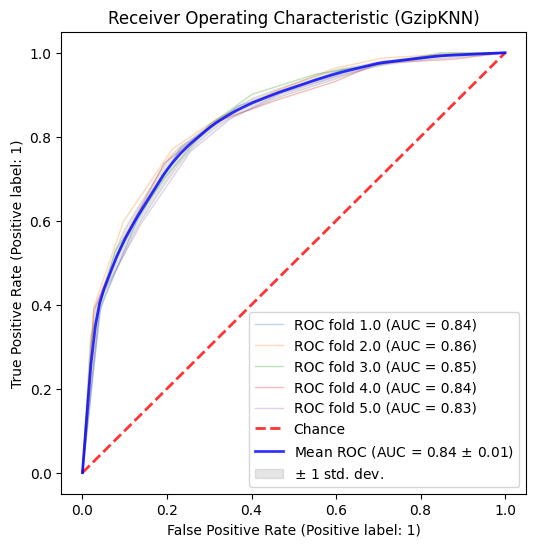

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [9]:
from qsprpred.plotting.classification import ROCPlot

plot = ROCPlot([model])
plot.make(save=True, show=True, property_name="pchembl_value_Median_class", validation="cv")

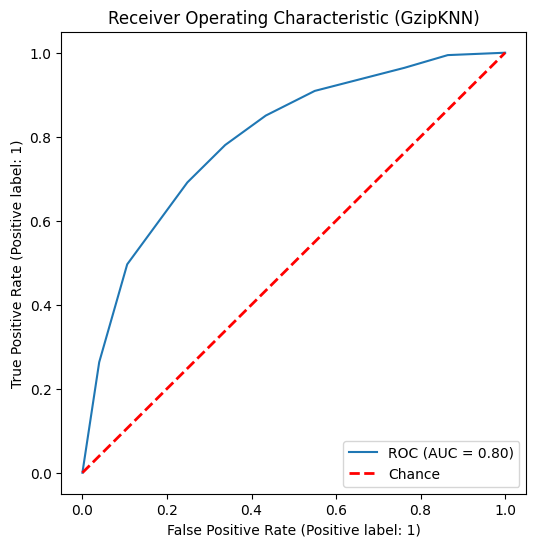

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [10]:
from qsprpred.plotting.classification import ROCPlot

plot = ROCPlot([model])
plot.make(save=True, show=True, property_name="pchembl_value_Median_class", validation="ind")

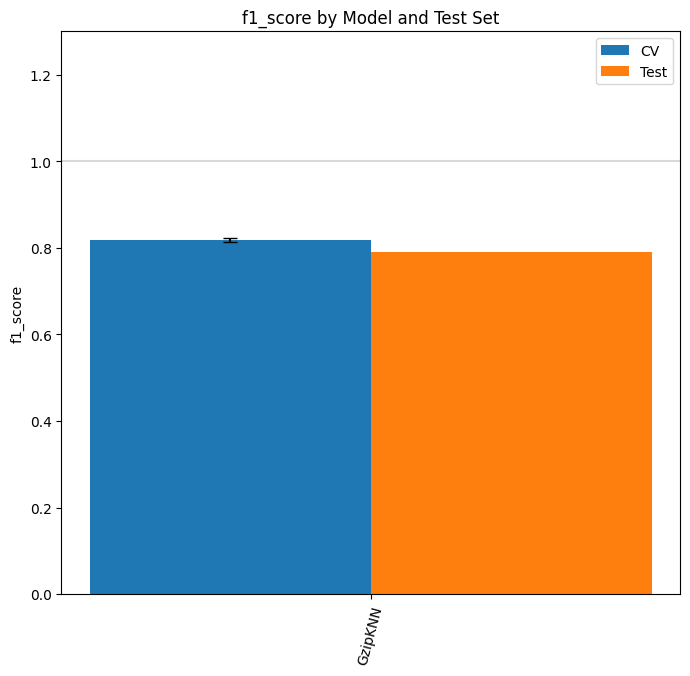

<Figure size 640x480 with 0 Axes>

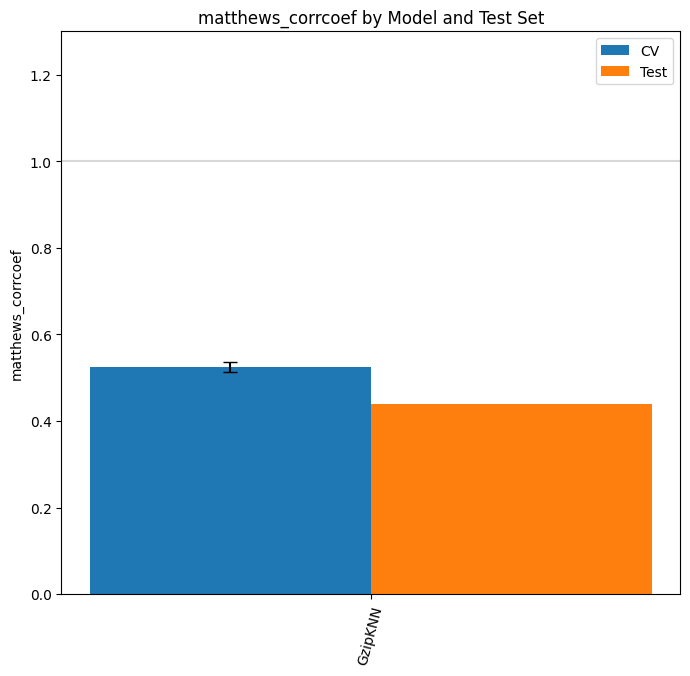

<Figure size 640x480 with 0 Axes>

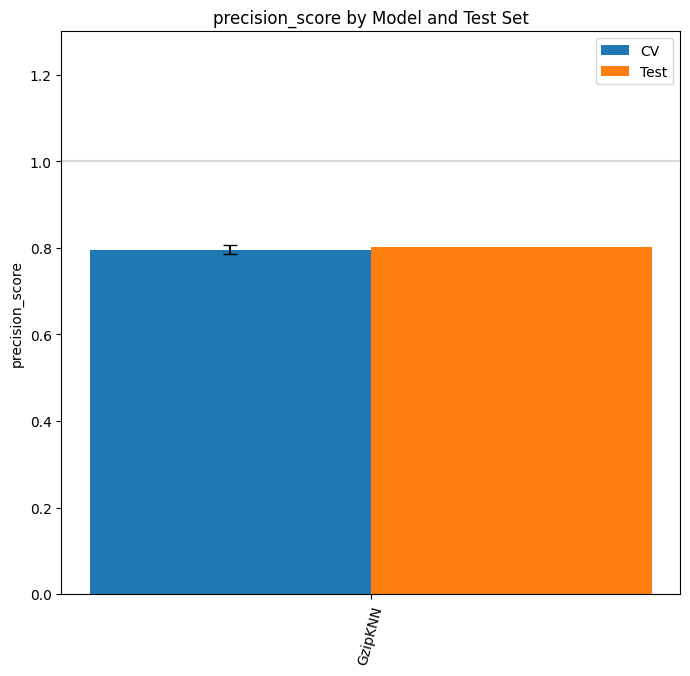

<Figure size 640x480 with 0 Axes>

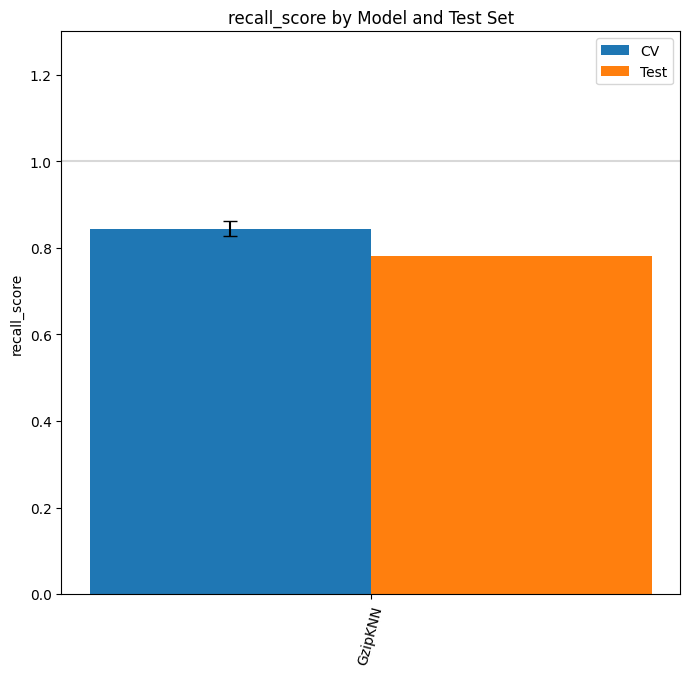

<Figure size 640x480 with 0 Axes>

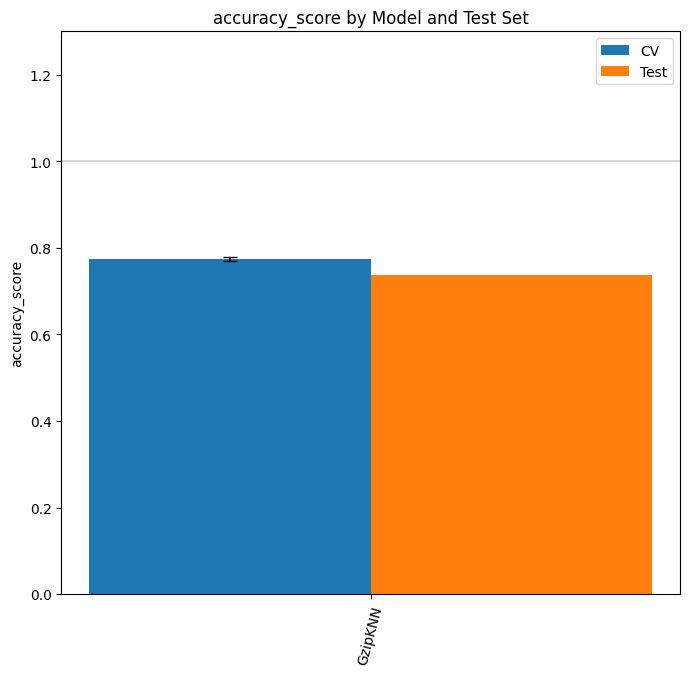

<Figure size 640x480 with 0 Axes>

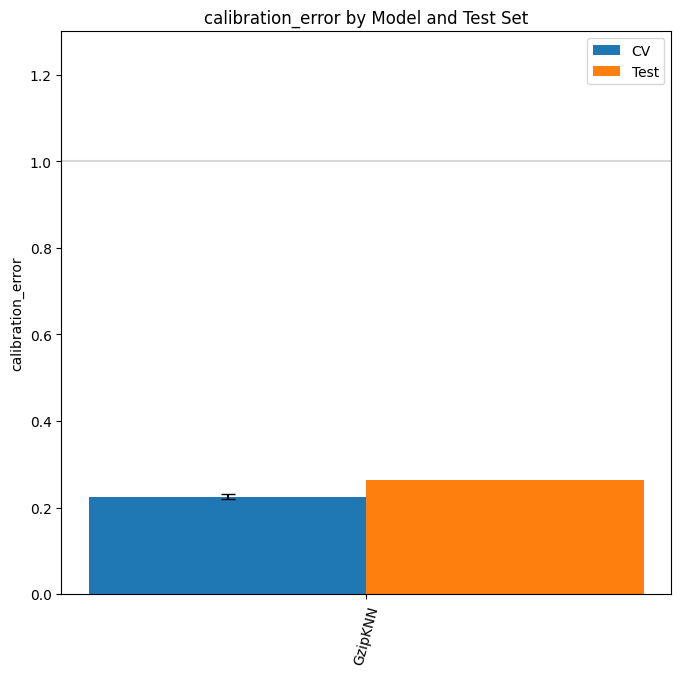

<Figure size 640x480 with 0 Axes>

In [11]:
from qsprpred.plotting.classification import MetricsPlot

plot = MetricsPlot([model])
figs, summary = plot.make(save=True, show=True, property_name="pchembl_value_Median_class", out_dir="qspr/models/")